# HVAC BOQ Agent – Business & Data Science Capstone (Kaggle Notebook)

This notebook is a capstone project built on top of the **Kaggle 5-Day Agents Course** and your **HVAC BOQ dataset**.

We will:

- Load and clean the HVAC BOQ dataset  
- Do basic **EDA** (business + data understanding)  
- Build an **HVAC BOQ Agent** using **Google ADK + Gemini** that can:
  - 🔍 Smart search BOQ items (e.g. “300mm pipe”)  
  - 💰 Create simple quotes based on item code + quantity  
  - ⚠️ Detect potential **cost anomalies** (overpriced items)  

This project is both:
- **Business-focused**: quotation, budgeting, anomaly alerts
- **Data-science-focused**: cleaning, EDA, simple anomaly detection

> 🔑 Prerequisite: You must have a `GOOGLE_API_KEY` secret set in Kaggle (Add-ons → Secrets).


In [1]:
# Core Python imports
import os
import json
import uuid

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Kaggle secrets for Gemini API key
from kaggle_secrets import UserSecretsClient

# ADK / Gemini imports
from google.adk.agents import LlmAgent
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.adk.models.google_llm import Gemini
from google.genai import types

# Hide some warnings if they get noisy
import warnings
warnings.filterwarnings("ignore")

print("✅ Imports loaded.")

✅ Imports loaded.


In [2]:
# Get GOOGLE_API_KEY from Kaggle Secrets and set as environment variable
try:
    user_secrets = UserSecretsClient()
    GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ GOOGLE_API_KEY loaded and environment variable set.")
except Exception as e:
    print(
        "🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' "
        "to your Kaggle secrets. Details:", e
    )

# Configure retry options for Gemini calls (same pattern as course)
retry_config = types.HttpRetryOptions(
    attempts=5,
    exp_base=7,
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],
)

print("✅ Retry configuration set.")

✅ GOOGLE_API_KEY loaded and environment variable set.
✅ Retry configuration set.


## 4. Build the HVAC BOQ Agent (with ADK + Gemini)

We’ll create:

- An `LlmAgent` called `hvac_boq_agent`
- It will use:
  - Model: `gemini-2.5-flash-lite`
  - Our 3 tools as function-calling tools
- Instructions tell the agent **how and when** to use each tool.


In [5]:
# Path to your BOQ dataset file
DATA_PATH = "Boq_dataset.csv"  # change if needed

def load_hvac_boq(path: str = '/kaggle/input/hvac-boq-dataset/Boq_dataset.csv') -> pd.DataFrame:
    """Load and clean the HVAC BOQ dataset."""
    df = pd.read_csv(path)

    # Strip extra spaces from column names (e.g. "Item code ")
    df.columns = [c.strip() for c in df.columns]

    # Clean Price: remove commas, convert to float
    df["Price"] = (
        df["Price"]
        .astype(str)
        .str.replace(",", "", regex=False)
        .str.strip()
    )
    df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

    # Fill missing Measurement Unit if exists
    if "Measurement Unit" in df.columns:
        df["Measurement Unit"] = df["Measurement Unit"].fillna("Unit")

    return df


df = load_hvac_boq()

print("✅ Dataset loaded and cleaned.\n")
print(df.head())
print("\n--- Info ---")
print(df.info())
print("\n--- Describe (numeric) ---")
print(df.describe())


✅ Dataset loaded and cleaned.

   Item code  Item Category  \
0          1        Service   
1          2  Piping Works    
2          3  Piping Works    
3          4  Piping Works    
4          5  Piping Works    

                                           Item Name Measurement Unit  \
0  Operation and maintenance of the HVAC at Tiger...            Month   
1                           Pipe dia : 300mm, Sch-40              RFT   
2                           Pipe dia : 200mm, Sch-40              RFT   
3                           Pipe dia : 150mm, Sch-40              RFT   
4                           Pipe dia : 100mm, Sch-40              RFT   

      Price  
0  150000.0  
1    2450.0  
2    2200.0  
3    2000.0  
4    1850.0  

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Item code         743 non-null    int64  


## 2. Quick Exploratory Data Analysis (EDA)

We’ll answer:

- How many items per **Item Category**?
- What is the **average price** per category?
- What does the **price distribution** look like?


📊 Items per category:
 Item Category
RTAG Air Cooled Rotary Liquid Chiller(Set: 01 & 02- RTAG205P, 200 TR, COP: 3.15, Two Ckt, Refrigerant: R134a,  MFD: 10/2019, Traine China\n , Set-03: RTAG125P  125TR, COP: 3.21,  Two Ckt,  Refrigerant: R134a, MFD 11/2020, Trane, China)    167
Supply Items                                                                                                                                                                                                                                   121
Cabinet and Metal Parts to make a complete AHU # 1-17[ Ground- Level-7]                                                                                                                                                                         71
Others Service items                                                                                                                                                                                                                      

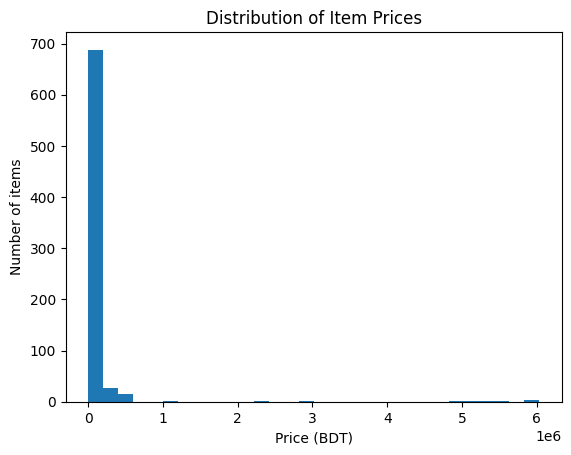

In [6]:
# Number of items per category
category_counts = df["Item Category"].value_counts()
print("📊 Items per category:\n", category_counts)

# Average price per category
avg_price_by_cat = df.groupby("Item Category")["Price"].mean().sort_values(ascending=False)
print("\n💰 Average price by category:\n", avg_price_by_cat)

# Optional: Plot price distribution
plt.hist(df["Price"].dropna(), bins=30)
plt.xlabel("Price (BDT)")
plt.ylabel("Number of items")
plt.title("Distribution of Item Prices")
plt.show()


## 3. Define Agent Tools

We’ll define three tools that the agent can call:

1. `search_items(query, top_k)`  
   - Smart search by text in **Item Name** and **Item Category**

2. `create_quote(item_code, quantity)`  
   - Single-line quote: unit price × quantity

3. `detect_cost_anomalies(category)`  
   - Simple **IQR-based** anomaly detection within each category  
   - Helps spot potentially overpriced items


In [8]:
from typing import Dict, Any

# Ensure df is available from previous cells
# df = load_hvac_boq()  # if needed


def search_items(query: str, top_k: int = 5) -> Dict[str, Any]:
    """
    Search for items whose name or category matches the query text.

    Args:
        query: Free-text search, e.g. "300mm pipe"
        top_k: Max number of results to return

    Returns:
        dict with a list of matching items (as records)
    """
    mask_name = df["Item Name"].str.contains(query, case=False, na=False)
    mask_cat = df["Item Category"].str.contains(query, case=False, na=False)
    mask = mask_name | mask_cat

    results = df[mask].head(top_k).copy()

    return {
        "query": query,
        "top_k": top_k,
        "results": results.to_dict(orient="records"),
    }


def create_quote(item_code: int, quantity: float) -> Dict[str, Any]:
    """
    Create a simple quote for a single BOQ line item.

    Args:
        item_code: Item code from the dataset.
        quantity: Quantity in the item's measurement unit.

    Returns:
        dict with item info and total cost.
    """
    row = df[df["Item code"] == item_code]

    if row.empty:
        return {
            "success": False,
            "message": f"No item found with Item code = {item_code}.",
        }

    row = row.iloc[0]
    unit_price = float(row["Price"])
    total = unit_price * quantity

    return {
        "success": True,
        "item_code": int(row["Item code"]),
        "item_name": row["Item Name"],
        "item_category": row["Item Category"],
        "unit": row["Measurement Unit"],
        "unit_price": unit_price,
        "quantity": quantity,
        "total_cost": total,
        "message": (
            f"Quote for {quantity} {row['Measurement Unit']} of "
            f"'{row['Item Name']}': {total:.2f} BDT "
            f"(unit price {unit_price:.2f} BDT)."
        ),
    }


def detect_cost_anomalies(category: str = "") -> Dict[str, Any]:
    """
    Detect high-price anomalies using a simple IQR rule within each category.

    Args:
        category: Optional. If provided, only check this category.
                  If empty string, check all categories.

    Returns:
        dict with a list of anomaly records.
    """
    if category.strip():
        data = df[df["Item Category"].str.lower() == category.lower()]
        checked_categories = [category]
    else:
        data = df.copy()
        checked_categories = sorted(df["Item Category"].unique().tolist())

    if data.empty:
        return {
            "success": False,
            "message": f"No data found for category '{category}'.",
            "anomalies": [],
        }

    anomalies_list = []

    # Apply IQR-based detection per category
    for cat, group in data.groupby("Item Category"):
        prices = group["Price"].dropna()
        if len(prices) < 4:
            continue  # too few items

        q1 = prices.quantile(0.25)
        q3 = prices.quantile(0.75)
        iqr = q3 - q1
        upper_threshold = q3 + 1.5 * iqr

        is_anomaly = group["Price"] > upper_threshold
        group_anomalies = group[is_anomaly]

        if not group_anomalies.empty:
            anomalies_list.extend(group_anomalies.to_dict(orient="records"))

    return {
        "success": True,
        "checked_categories": checked_categories,
        "anomalies": anomalies_list,
        "message": f"Found {len(anomalies_list)} potential high-price anomalies.",
    }


print("✅ Tools defined: search_items, create_quote, detect_cost_anomalies.")


✅ Tools defined: search_items, create_quote, detect_cost_anomalies.


## 4. Build the HVAC BOQ Agent (with ADK + Gemini)

We’ll create:

- An `LlmAgent` called `hvac_boq_agent`
- It will use:
  - Model: `gemini-2.5-flash-lite`
  - Our 3 tools as function-calling tools
- Instructions tell the agent **how and when** to use each tool.


In [9]:
hvac_boq_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="hvac_boq_agent",
    description=(
        "Agent for HVAC project quoting and BOQ handling. "
        "It can search items, create simple quotes, and detect price anomalies."
    ),
    instruction="""
You are an HVAC BOQ assistant for project supply, service, and maintenance.

You have access to tools that work on a BOQ dataset with the following columns:
- Item code
- Item Category
- Item Name
- Measurement Unit
- Price (BDT)

Your main skills:

1) Smart Search:
   - Use 'search_items' when the user asks to search, filter, or find items.
   - Show results in a clear table with item code, item name, unit, and price.

2) Quoting:
   - To create a cost quote for a specific item_code and quantity,
     use 'create_quote'.
   - If the user describes the item in words (e.g. '300mm pipe'),
     first use 'search_items' to find the most suitable item code,
     then call 'create_quote' with that code.
   - Always show line total and unit price.

3) Cost Anomaly Detection:
   - Use 'detect_cost_anomalies' when the user asks for overpriced or unusual items.
   - You can pass a specific category (e.g. 'Piping Works') or leave it empty
     to scan all categories.

Always:
- Explain what you did in simple terms.
- If you're not sure which item is correct, show multiple candidates and ask
  the user to pick an item code.
""",
    tools=[search_items, create_quote, detect_cost_anomalies],
)

print("✅ HVAC BOQ Agent created.")


✅ HVAC BOQ Agent created.


## 5. Session & Runner Helper (run_agent_once)

We’ll use ADK’s:

- `InMemorySessionService` for session handling  
- `Runner` to execute the agent  

`run_agent_once()` helper will:

1. Create a fresh session  
2. Send a single user message  
3. Print the final agent response


In [10]:
session_service = InMemorySessionService()

async def run_agent_once(user_message: str):
    """
    Run the hvac_boq_agent for a single user message and print the final reply.
    """
    app_name = "hvac_boq_app"
    user_id = "demo_user"
    session_id = f"demo_session_{uuid.uuid4().hex[:8]}"

    # 1) Create a fresh session
    await session_service.create_session(
        app_name=app_name,
        user_id=user_id,
        session_id=session_id,
    )

    runner = Runner(
        agent=hvac_boq_agent,
        app_name=app_name,
        session_service=session_service,
    )

    test_content = types.Content(parts=[types.Part(text=user_message)])

    print(f"👤 User: {user_message}")
    print("🤖 Agent:\n" + "-" * 60)

    async for event in runner.run_async(
        user_id=user_id,
        session_id=session_id,
        new_message=test_content,
    ):
        if event.is_final_response() and event.content:
            for part in event.content.parts:
                if hasattr(part, "text"):
                    print(part.text)

    print("-" * 60)

print("✅ Session service and run_agent_once helper ready.")


✅ Session service and run_agent_once helper ready.


## 6. Try Example Interactions

We’ll test:

1. 🔍 Smart search query  
2. 💰 Quote for a 300mm pipe quantity  
3. ⚠️ Cost anomaly detection  
4. 💼 A more complex project question (multiple items)


In [21]:
# 1) Smart search
await run_agent_once("Search items related to 300mm and show top 5.")

# 2) Simple quote
await run_agent_once("Create a quote for 100 RFT of Pipe dia : 300mm.")

# 3) Cost anomaly detection
await run_agent_once("Find any cost anomalies in Pipe dia : 300mm's category.")

# 4) Multi-item project question
await run_agent_once(
    "Estimate material cost for 200 RFT of Pipe dia : 300mm and 100 RFT of Item code 2."
)


👤 User: Search items related to 300mm and show top 5.
🤖 Agent:
------------------------------------------------------------


Here are the top 5 items related to '300mm':

| Item Code | Item Name                     | Unit | Price (BDT) |
|-----------|-------------------------------|------|-------------|
| 2         | Pipe dia : 300mm, Sch-40      | RFT  | 2450        |
| 25        | Pipe dia : 300mm              | RFT  | 2300        |
| 35        | 300mm dia                     | Nos  | 24000       |
| 54        | 300mm dia                     | nos  | 90400       |
| 65        | 300mm dia                     | Nos  | 58800       |

------------------------------------------------------------
👤 User: Create a quote for 100 RFT of Pipe dia : 300mm.
🤖 Agent:
------------------------------------------------------------


I found an item that matches your description: "Pipe dia : 300mm, Sch-40" with item code 2.

Here is the quote for 100 RFT:

Item Name: Pipe dia : 300mm, Sch-40
Quantity: 100 RFT
Unit Price: 2450.00 BDT
Total Cost: 245000.00 BDT
------------------------------------------------------------
👤 User: Find any cost anomalies in Pipe dia : 300mm's category.
🤖 Agent:
------------------------------------------------------------


I couldn't find any cost anomalies for the category 'Pipe dia : 300mm'. This could be because there are no items in that category or the existing items do not present any anomalies.
------------------------------------------------------------
👤 User: Estimate material cost for 200 RFT of Pipe dia : 300mm and 100 RFT of Item code 2.
🤖 Agent:
------------------------------------------------------------


I couldn't find an item with code 2015. However, I was able to generate a quote for 100 RFT of Item Code 2, 'Pipe dia : 300mm, Sch-40'. The total cost is 245,000.00 BDT, with a unit price of 2,450.00 BDT.

Would you like me to search for the pipe with 300mm diameter and generate a quote for that?
------------------------------------------------------------


## 7. Summary & Next Steps

### What this Capstone Demonstrates

**Business-focused:**
- HVAC-focused item search (pipes, services, fittings, etc.)
- Basic project quoting using BOQ and quantities
- Detection of unusual/high prices for review (cost anomaly detection)

**Data-science-focused:**
- Data cleaning (price parsing, missing units)
- Exploratory analysis by category and price
- Simple IQR-based anomaly detection per category

### Possible Extensions

- 📦 Multi-line quotes:
  - Parse a full BOQ (multiple item codes + quantities)
  - Return a total project cost and category-wise breakdown

- 🔁 Memory:
  - Remember typical discounts, preferred vendors, or standard margins

- 🤝 Agent2Agent:
  - Connect this BOQ agent to another **Project Management Agent** using A2A

- 📊 Visualization:
  - Add plots for project cost over time, cost per system (ducting, piping, equipment, etc.)

---


